# 🛍️ Multimodal Fashion product search via Text, Image using Amazon S3 Vector Buckets (RRF based)

In [1]:
import os
import math
import json
from pathlib import Path
from collections import defaultdict
import textwrap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import boto3
from transformers import CLIPProcessor, CLIPModel, AutoImageProcessor, AutoModel
from sentence_transformers.SentenceTransformer import SentenceTransformer
from PIL import Image
import torch
from dotenv import load_dotenv
load_dotenv()
%matplotlib inline

In [2]:
np.random.seed(12345)

In [3]:
s3vectors = boto3.client("s3vectors")
bedrock = boto3.client("bedrock-runtime")

In [4]:
base_data_path = f"{Path().resolve().parent}/data/"
storage_bucket_name = os.environ.get("STORAGE_BUCKET_NAME")
vector_bucket_name = os.environ.get("VECTOR_BUCKET_NAME")
image_index_name = "img-index"
text_index_name = "txt-index"

In [5]:
iprocessor = AutoImageProcessor.from_pretrained("google/vit-base-patch16-224-in21k")
imodel = AutoModel.from_pretrained("google/vit-base-patch16-224-in21k")
t_model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")

Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.


In [6]:
images_df = pd.read_csv(f"{base_data_path}/fashion-dataset/images.csv")
style_df = pd.read_csv(f"{base_data_path}/fashion-dataset/styles.csv", on_bad_lines='skip')

In [7]:
style_df["id"] = style_df["id"].astype(str)
images_df["id"] = images_df.filename.str.replace(".jpg", "")

In [8]:
merged_df = images_df.merge(style_df, left_on=["id"], right_on=["id"], how="left")
merged_df = merged_df[merged_df.link != "undefined"]
sampled_df = merged_df[~merged_df["productDisplayName"].isna()].sample(n=10000)

In [9]:
sampled_df.reset_index(drop=True, inplace=True)

In [10]:
sampled_df["s3_uri"] = sampled_df["filename"].apply(lambda x: f"s3://{storage_bucket_name}/fashion-dataset/images/{x}")
sampled_df.fillna("", inplace=True)

In [11]:
def get_embeddings(inputs, mode):
    if mode == "image":
        img_inputs = iprocessor(images=inputs, return_tensors="pt")
        with torch.no_grad():
            outputs = imodel(**img_inputs)
            last_hidden_state = outputs.last_hidden_state[:, 0, :]
            features = last_hidden_state / last_hidden_state.norm(dim=1, keepdim=True)
            features = features.cpu().numpy().astype(np.float32)
            return [f.flatten().tolist() for f in features]
    if mode == "text":
        embeddings = t_model.encode(inputs)
        return [f.tolist() for f in embeddings]


In [12]:
def display_results(matches, query_text=None, query_image=None, is_rrf=False):
    max_cols = 7
    total = len(matches) + 1
    n_rows = math.ceil(total / max_cols)

    fig, axes = plt.subplots(n_rows, max_cols, figsize=(3 * max_cols, 5 * n_rows))
    axes = axes.flatten()

    query_path = os.path.join(f"{base_data_path}/fashion-dataset/test-images/{query_image}")
    if os.path.exists(query_path):
        img = mpimg.imread(query_path)
        axes[0].imshow(img)
        axes[0].axis("off")
        axes[0].set_title(f"Query Text:\n{textwrap.fill(str(query_text), width=25)}", fontsize=9)
    else:
        axes[0].text(0.5, 0.5, f"Query Text:\n{textwrap.fill(str(query_text), width=25)}", ha='center', va='center')
        axes[0].axis("off")

    for i, match in enumerate(matches):
        idx = i + 1
        match_path = os.path.join(f"{base_data_path}/fashion-dataset/images/{match['key']}.jpg")
        if os.path.exists(match_path):
            img = mpimg.imread(match_path)
            axes[idx].imshow(img)
            axes[idx].axis("off")
            product_name = match["metadata"].get("productName", "N/A")
            wrapped_name = textwrap.fill(product_name, width=20)
            if is_rrf:
                title = f"{match["key"]}\n{wrapped_name}\nrrf_score: {match["rrf_score"]:.4f}"
            else:
                title = f"{match["key"]}\n{wrapped_name}\nDist: {match["distance"]:.4f}"
            axes[idx].set_title(title, fontsize=8)
        else:
            axes[idx].text(0.5, 0.5, "Image not found", ha="center", va="center")
            axes[idx].axis("off")

    for i in range(total, len(axes)):
        axes[i].axis("off")

    plt.tight_layout()


In [13]:
def create_and_upload_vectors(df, vector_bucket_name, image_index_name, text_index_name, batch_size=500):
    for i in range(0, len(df), batch_size):
        image_vectors, text_vectors = [], []
        
        batch = df.iloc[i:i+batch_size]
        
        images_batch = [Image.open(f"{base_data_path}fashion-dataset/images/{f}").convert("RGB") for f in batch["filename"]]
        text_batch = batch["productDisplayName"].tolist()
    
        image_embeddings = get_embeddings(images_batch, mode="image")
        text_embeddings = get_embeddings(text_batch, mode="text")
    
        for ind, v in enumerate(batch.itertuples()):
            metadata = {"gender": v.gender, "category": v.masterCategory, "type": v.usage, "season": v.season, "productName": v.productDisplayName, "s3_uri": v.s3_uri}
            text_vectors.extend([{
                "key": f"{v.id}",
                "data": {"float32" : text_embeddings[ind]},
                "metadata": metadata}])
            image_vectors.extend([{
                "key": f"{v.id}",
                "data": {"float32" : image_embeddings[ind]},
                "metadata": metadata}])
        
        s3vectors.put_vectors(
            vectorBucketName=vector_bucket_name,   
            indexName=image_index_name,
            vectors=image_vectors
        )
        s3vectors.put_vectors(
            vectorBucketName=vector_bucket_name,   
            indexName=text_index_name,
            vectors=text_vectors
        )


In [14]:
def query_s3_vectors(bucket_name, index_name, vector, k=5):
    response = s3vectors.query_vectors(
            vectorBucketName=bucket_name,
            indexName=index_name,
            queryVector={"float32": vector}, 
            topK=k, 
            returnDistance=True,
            returnMetadata=True
        )
    return response["vectors"]
    

In [15]:
def rrf_merge(image_results, text_results, k=60, top_k=20):
    scores = defaultdict(float)
    rank_sources = {"image": image_results, "text": text_results}

    for source_name, result_list in rank_sources.items():
        for rank, item in enumerate(result_list):
            doc_id = item["key"]
            scores[doc_id] += 1 / (k + rank + 1)
    metadata = {item["key"]: item for item in image_results + text_results}

    fused = [
        {
            "key": doc_id,
            "rrf_score": round(score, 6),
            **metadata[doc_id]
        }
        for doc_id, score in sorted(scores.items(), key=lambda x: x[1], reverse=True)
    ]

    return fused[:top_k]


In [16]:
%%time
create_and_upload_vectors(sampled_df, vector_bucket_name, image_index_name, text_index_name, batch_size=500)

/Users/srcecde/Projects/work/youtube/s3-vectors-bucket/repo/s3-vector-buckets-search/.venv/lib/python3.13/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


CPU times: user 13min 14s, sys: 5min 18s, total: 18min 32s
Wall time: 7min 48s


In [17]:
input_text = ["mens green polo tshirt"]
query_image = "t-shirt.webp"
input_image = [Image.open(f"{base_data_path}/fashion-dataset/test-images/{query_image}").convert("RGB")]
t_emb = get_embeddings(input_text, mode="text")
i_emb = get_embeddings(input_image, mode="image")

In [24]:
image_match = query_s3_vectors(bucket_name=vector_bucket_name, vector=i_emb[0], k=10, index_name="img-index")
text_match = query_s3_vectors(bucket_name=vector_bucket_name, vector=t_emb[0], k=10, index_name="txt-index")

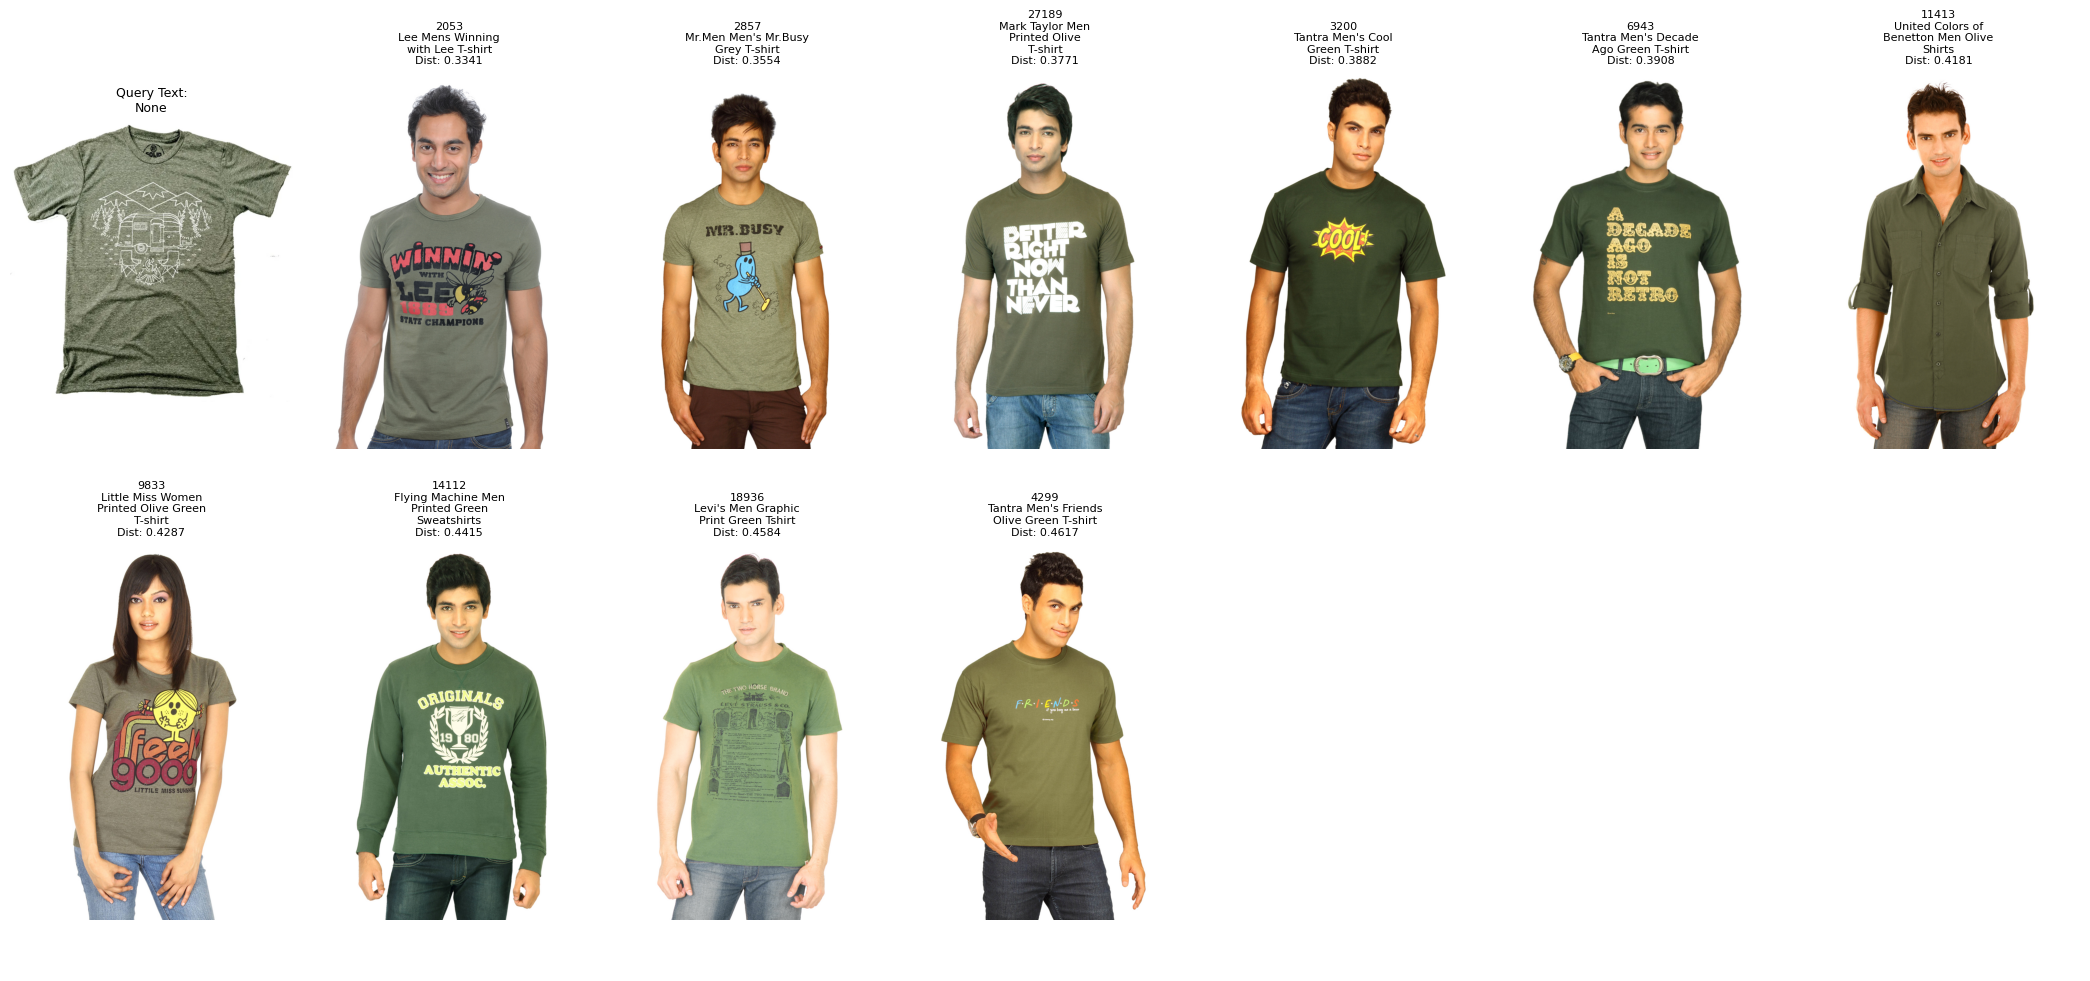

In [19]:
display_results(image_match, query_image=query_image)

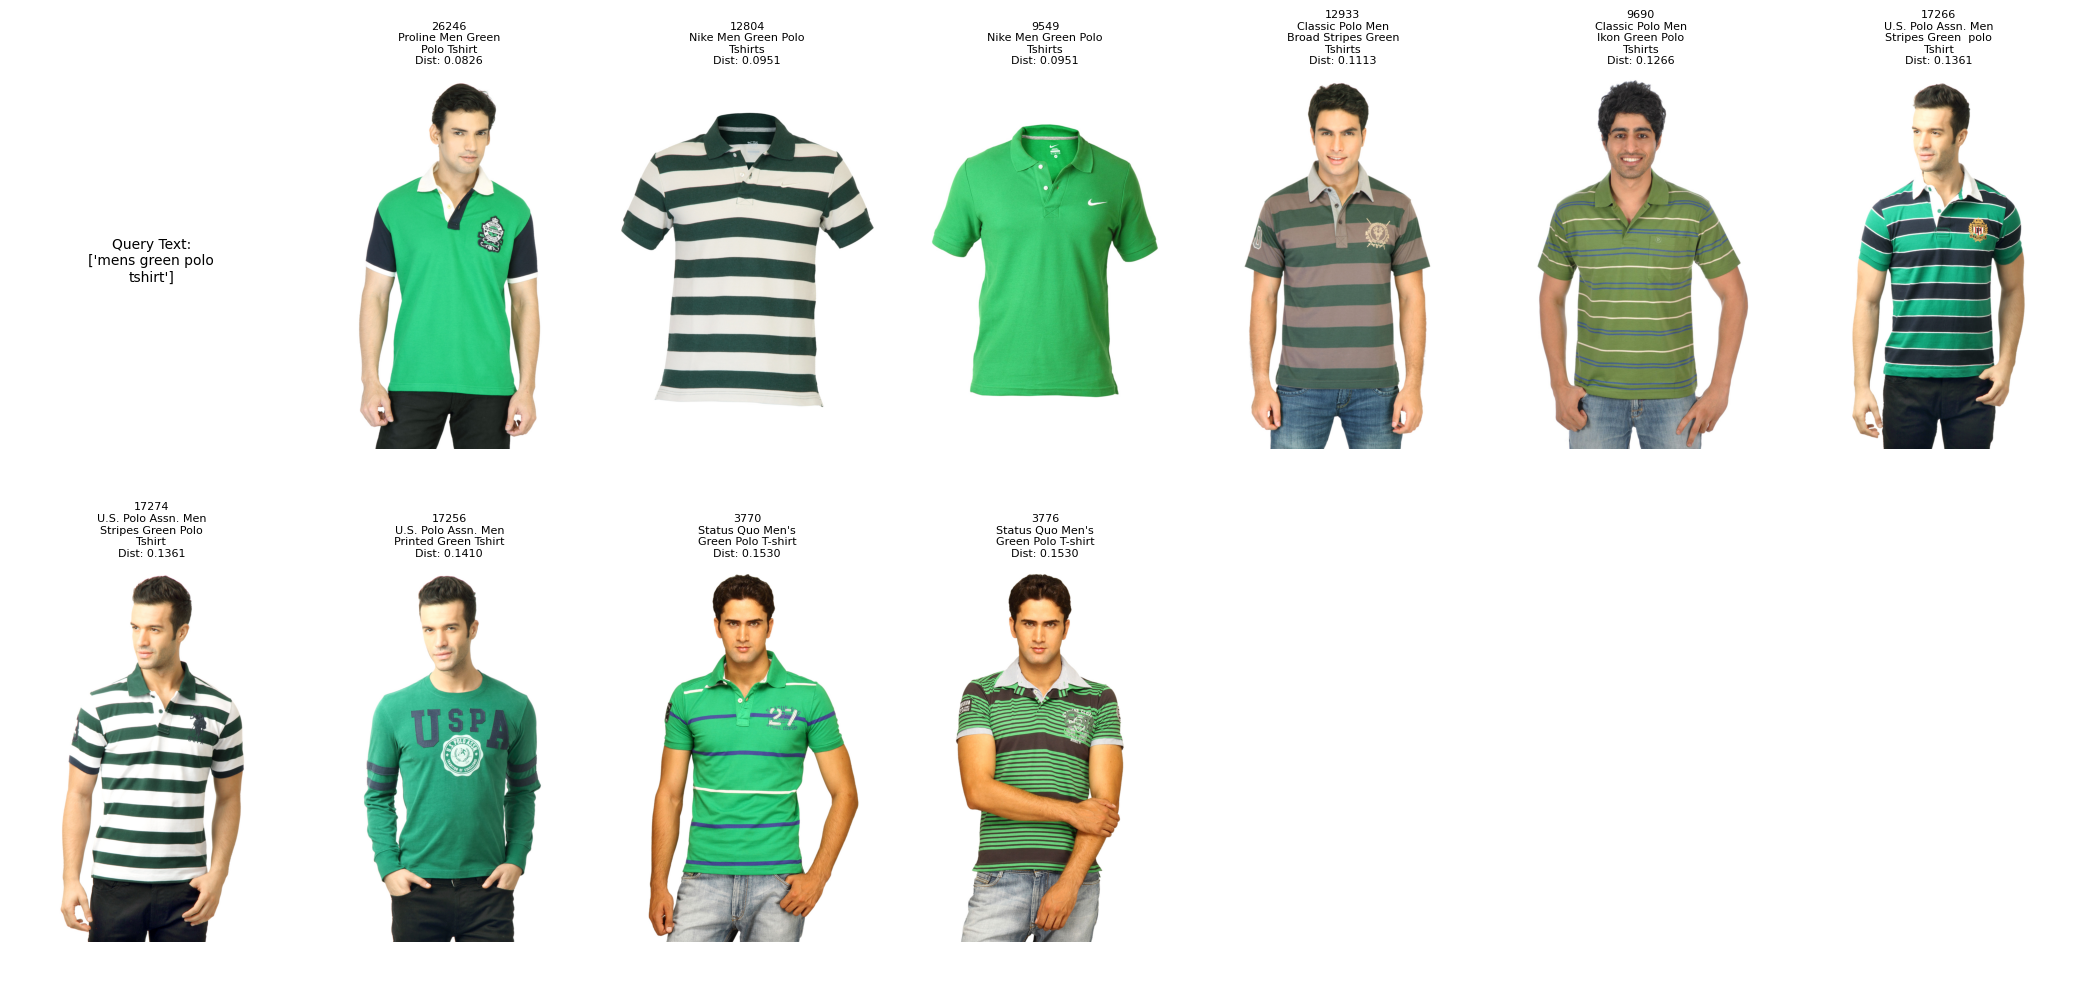

In [20]:
display_results(text_match, query_text=input_text, query_image=None)

In [21]:
# RRF fused
fused_results = rrf_merge(image_results=image_match, text_results=text_match, top_k=20)

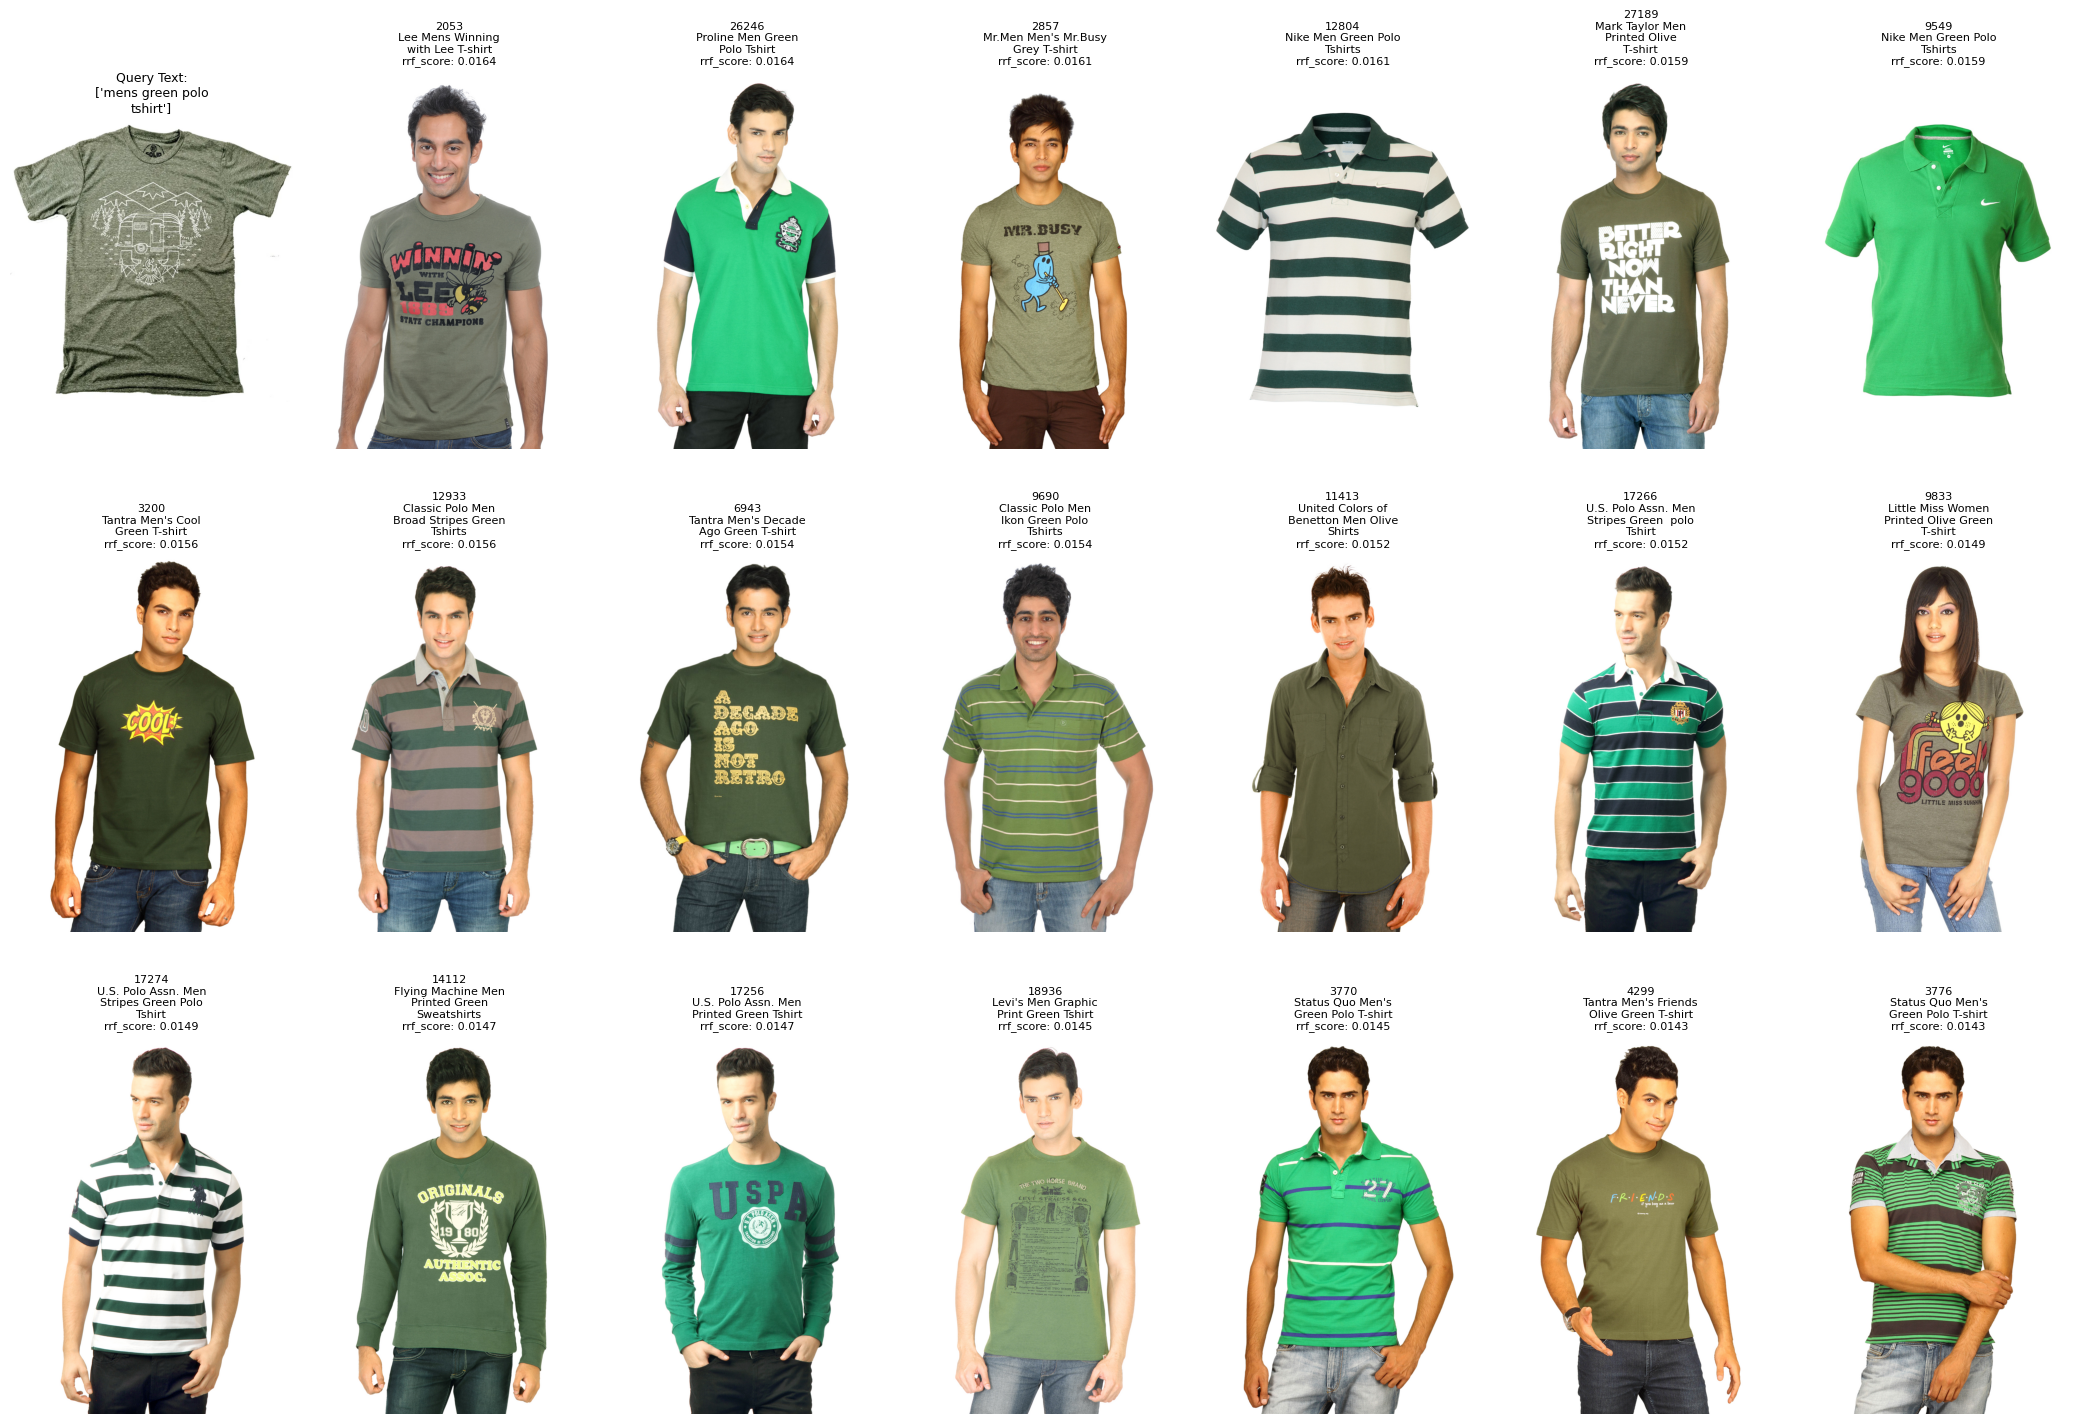

In [22]:
display_results(fused_results, query_text=input_text, query_image=query_image, is_rrf=True)